This cell loads the dataset, selects relevant columns. It extracts datetime features from the 'SystemTime' column and defines lists of categorical and numerical columns for further processing. It also initializes variables for cross-validation.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn import metrics
from keras import layers, losses, Model, initializers, optimizers, regularizers
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler


x = pd.read_csv(r'/content/drive/MyDrive/data/LMD-2023 [1.75M Elements][Labelled]checked.csv',low_memory=False)

#Select relevant features
cols = ['Computer', 'DestinationPortName', 'EventID', 'EventRecordID', 'Execution_ProcessID',
        'Initiated', 'ProcessId', 'SourceIsIpv6', 'SystemTime', 'Label']


x = x[cols]
y = x['Label'].copy()
y = np.where(y > 0, 1, 0)
x = x.drop(columns=['Label'])



# Extract datetime features
x['SystemTime'] = pd.to_datetime(x['SystemTime'])
x['year'] = x['SystemTime'].dt.year
x['month'] = x['SystemTime'].dt.month
x['week'] = x['SystemTime'].dt.isocalendar().week
x['day'] = x['SystemTime'].dt.day
x['hour'] = x['SystemTime'].dt.hour
x['minute'] = x['SystemTime'].dt.minute
x['day_of_week'] = x['SystemTime'].dt.dayofweek
x = x.drop(columns=['SystemTime'])

categorical_cols = ['Computer', 'DestinationPortName', 'EventID', 'Initiated', 'SourceIsIpv6', 'year', 'month', 'week',
                    'day_of_week']
numerical_cols = ['EventRecordID', 'Execution_ProcessID', 'ProcessId', 'day', 'hour', 'minute']

skf = StratifiedShuffleSplit(n_splits=10, test_size=0.25)

all_fold_metrics = []
all_fold_histories = []
all_fold_models = []


This cell defines a custom Keras Model called AnomalyDetector. This model implements an autoencoder architecture consisting of an encoder and a decoder. The encoder progressively reduces the dimensionality of the input data through dense layers, batch normalization, and dropout. The decoder reconstructs the input data from the encoded representation using a similar structure. The model is designed for anomaly detection by learning to reconstruct normal data.


In [ ]:
@keras.saving.register_keras_serializable()
class AnomalyDetector(Model):
  def __init__(self, *args, **kwargs):
    super(AnomalyDetector, self).__init__()
    self.encoder = keras.Sequential([
        layers.Flatten(input_shape=(args[0],)),
      layers.Dense(50, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.BatchNormalization(),
      layers.Dropout(0.15),
      layers.Dense(30, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.BatchNormalization(),
      layers.Dropout(0.15),
      layers.BatchNormalization(),
      layers.Dense(20, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.15),
      layers.BatchNormalization(),
        layers.Dense(10, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.Dropout(0.15),
      layers.BatchNormalization(),
      layers.Dense(5, activation="relu",kernel_initializer=initializers.HeNormal()),
      layers.BatchNormalization(),
       layers.Dropout(0.15)])


    self.decoder = keras.Sequential([
      layers.Dense(10, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.BatchNormalization(),
      layers.Dropout(0.15),
      layers.Dense(20, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.BatchNormalization(),
      layers.Dropout(0.15),
      layers.Dense(30, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.BatchNormalization(),
      layers.Dropout(0.15),
      layers.Dense(50, activation="relu",kernel_initializer=initializers.HeNormal(), kernel_regularizer=regularizers.l2(0.01)),
      layers.BatchNormalization(),
    layers.Dropout(0.15),
      layers.Dense(args[0], activation="sigmoid",kernel_initializer=initializers.GlorotNormal(), kernel_regularizer=regularizers.l2(0.01))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded





This cell performs a 10-fold stratified shuffle split cross-validation. In each fold, it splits the data into training and testing sets, preprocesses the categorical features using OneHotEncoder and numerical features using MinMaxScaler. It then trains the AE model on the normal samples of the training data, saves the trained model, computes the optimal threshold for anomaly detection based on the F1 score on the training data, and evaluates the model's performance on the test data using various metrics (AUC, Accuracy, Precision, Recall, and F1 Score). Finally, it plots histograms of the reconstruction loss for normal and anomaly data in  the training set and stores the metrics and trained models

Fold 1:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.3497 - val_loss: 0.1886
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 108s 4ms/step - loss: 0.1147 - val_loss: 0.1614
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.1079 - val_loss: 0.1603
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.1042 - val_loss: 0.1561
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.1030 - val_loss: 0.1561
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 106s 4ms/step - loss: 0.1014 - val_loss: 0.1518
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.1007 - val_loss: 0.1523
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.1000 - val_loss: 0.1531
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.0991 - val_loss: 0.1541
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 108s 4ms/step - loss: 0.0987 - val_loss: 0.1548
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 107s 4ms/step - loss: 0.0979 - val

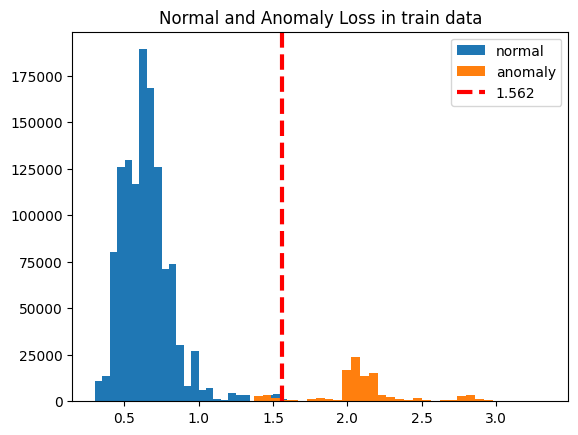

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
fold1 results
Auc: 0.9990139317292686
Accuracy: 0.991625000855756
Precision: 0.9838186712345528
Recall: 0.9110299116247451
F1 Score: 0.946026236837461
Fold 2:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 129s 5ms/step - loss: 0.3568 - val_loss: 0.1732
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - loss: 0.1127 - val_loss: 0.1802
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 113s 5ms/step - loss: 0.1068 - val_loss: 0.1703
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - loss: 0.1047 - val_loss: 0.1705
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.1014 - val_loss: 0.1690
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.1003 - val_loss: 0.1688
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.1033 - val_loss: 0.1671
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.1015 - val_loss: 0.1599
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.0965 - val_loss: 0.1506
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - loss: 0.0957 - val_loss: 0.1500
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 112s 5ms/step - loss: 0.0976 - val

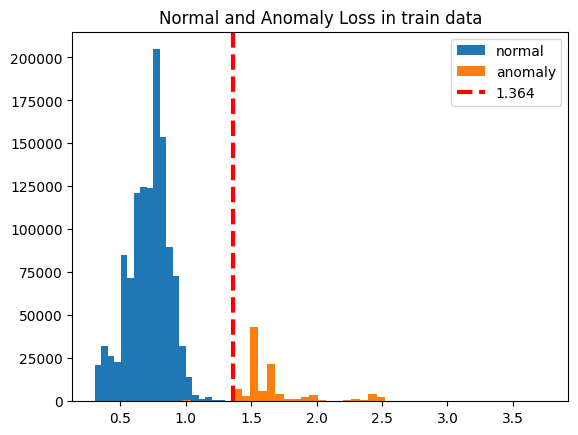

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
fold2 results
Auc: 0.9986337989330506
Accuracy: 0.9961388287324086
Precision: 0.961931724479138
Recall: 0.9913041015182416
F1 Score: 0.97639706497782
Fold 3:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 131s 5ms/step - loss: 0.3470 - val_loss: 0.2159
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - loss: 0.1106 - val_loss: 0.1977
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - loss: 0.1058 - val_loss: 0.2005
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.1042 - val_loss: 0.2137
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1033 - val_loss: 0.2047
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1025 - val_loss: 0.2065
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1020 - val_loss: 0.2041
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1017 - val_loss: 0.2023
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1014 - val_loss: 0.1964
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1011 - val_loss: 0.1965
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.1016 - val

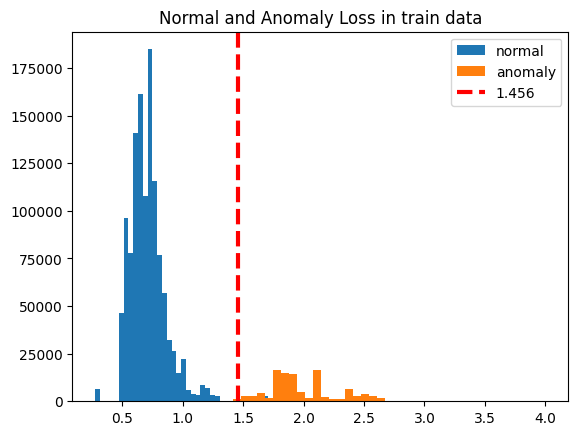

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
fold3 results
Auc: 0.9993074622120413
Accuracy: 0.9945528275320681
Precision: 0.9426826972215498
Recall: 0.9927486970314978
F1 Score: 0.9670681401156133
Fold 4:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 133s 5ms/step - loss: 0.4167 - val_loss: 0.2616
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 118s 5ms/step - loss: 0.2285 - val_loss: 0.2650
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.2281 - val_loss: 0.2649
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.2278 - val_loss: 0.2656
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.2276 - val_loss: 0.2659
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.2277 - val_loss: 0.2666
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.2276 - val_loss: 0.2670
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.2277 - val_loss: 0.2672
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.2277 - val_loss: 0.2674
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.2277 - val_loss: 0.2674
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.2277 - val

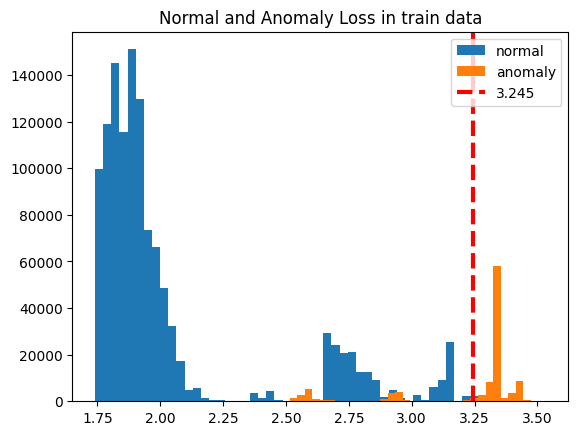

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
fold4 results
Auc: 0.9800741109871745
Accuracy: 0.9833823586462168
Precision: 0.9971613086367185
Recall: 0.7960004532064355
F1 Score: 0.8852975459156349
Fold 5:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 134s 5ms/step - loss: 0.3529 - val_loss: 0.1855
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1154 - val_loss: 0.1767
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.1122 - val_loss: 0.1748
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.1099 - val_loss: 0.1687
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1077 - val_loss: 0.1677
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.1065 - val_loss: 0.1694
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1067 - val_loss: 0.1768
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.1089 - val_loss: 0.1809
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 118s 5ms/step - loss: 0.1084 - val_loss: 0.1831
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.1073 - val_loss: 0.1836
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.1074 - val

/tmp/ipython-input-1157703784.py:52: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * precision * recall / (precision + recall)


Threshold: 2.5602252570055644
37773/37773 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step
3310/3310 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


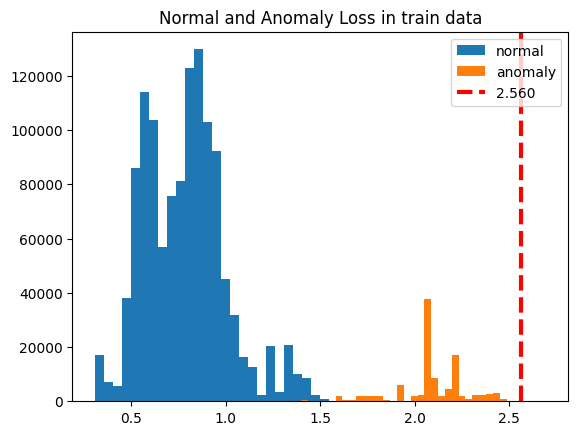

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
fold5 results
Auc: 0.9995346217368962
Accuracy: 0.9194265749904725
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Fold 6:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 137s 5ms/step - loss: 0.3600 - val_loss: 0.2032
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.1118 - val_loss: 0.1968
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.1055 - val_loss: 0.1815
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.1023 - val_loss: 0.1925
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.1001 - val_loss: 0.1968
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.0972 - val_loss: 0.1981
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.0964 - val_loss: 0.1962
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.0956 - val_loss: 0.1975
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 0.0950 - val_loss: 0.2078
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - loss: 0.0947 - val_loss: 0.2045
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - loss: 0.0930 - val

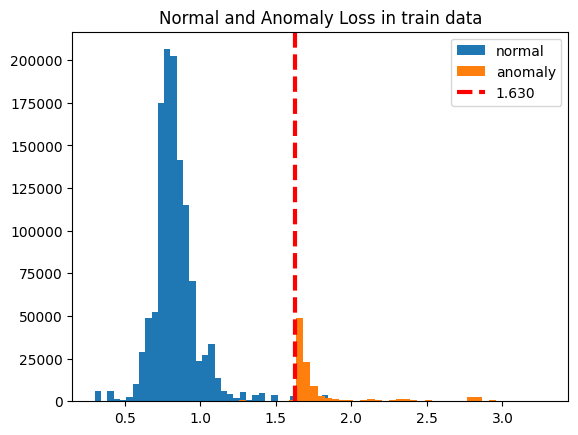

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step
fold6 results
Auc: 0.992761982176278
Accuracy: 0.9909426780371923
Precision: 0.9064518639582847
Recall: 0.9897178789938818
F1 Score: 0.9462566519072186
Fold 7:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 133s 5ms/step - loss: 0.3480 - val_loss: 0.1684
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 0.1197 - val_loss: 0.2577
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 0.1153 - val_loss: 0.1749
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.1134 - val_loss: 0.1616
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1105 - val_loss: 0.1961
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1093 - val_loss: 0.1729
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.1088 - val_loss: 0.2000
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.1074 - val_loss: 0.1733
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.1059 - val_loss: 0.1605
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 0.1047 - val_loss: 0.1510
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 115s 5ms/step - loss: 0.1028 - val

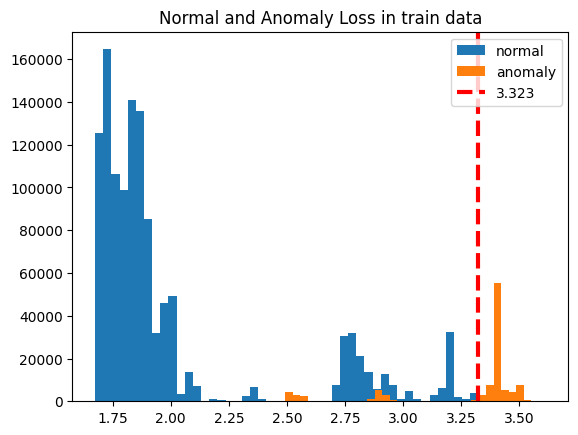

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
fold7 results
Auc: 0.9784041657574036
Accuracy: 0.9838113776759492
Precision: 0.9984098939929329
Recall: 0.8003342397462044
F1 Score: 0.8884661342053959
Fold 8:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 135s 5ms/step - loss: 0.3578 - val_loss: 0.1724
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.1135 - val_loss: 0.1604
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1099 - val_loss: 0.1711
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1079 - val_loss: 0.1722
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.1068 - val_loss: 0.1667
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.1061 - val_loss: 0.1727
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.1056 - val_loss: 0.1757
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.1043 - val_loss: 0.1741
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 116s 5ms/step - loss: 0.1025 - val_loss: 0.1770
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.1013 - val_loss: 0.1678
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.1009 - val

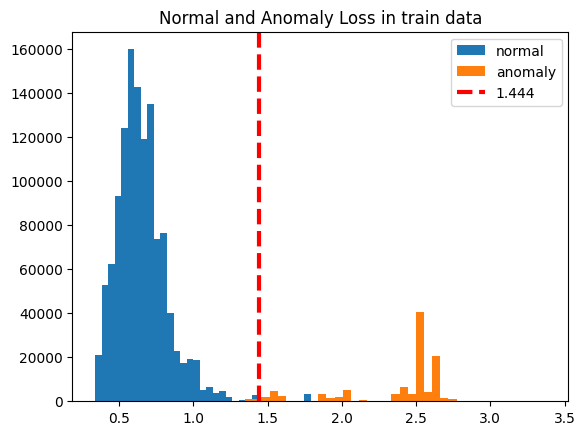

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
fold8 results
Auc: 0.9996051700246426
Accuracy: 0.9959288832497735
Precision: 0.9627533270749351
Recall: 0.9876784500339905
F1 Score: 0.9750566259332792
Fold 9:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 133s 5ms/step - loss: 0.3576 - val_loss: 0.2120
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1230 - val_loss: 0.2436
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1142 - val_loss: 0.2011
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 123s 5ms/step - loss: 0.1115 - val_loss: 0.1816
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.1102 - val_loss: 0.2113
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 0.1094 - val_loss: 0.2127
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 125s 5ms/step - loss: 0.1086 - val_loss: 0.2353
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.1080 - val_loss: 0.2286
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - loss: 0.1076 - val_loss: 0.1984
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 124s 5ms/step - loss: 0.1074 - val_loss: 0.2082
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 126s 5ms/step - loss: 0.1072 - val

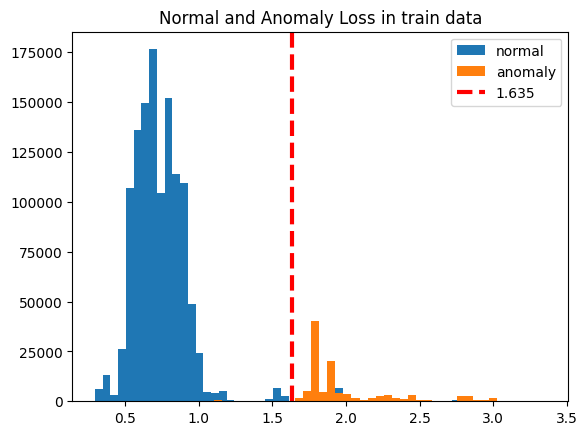

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
fold9 results
Auc: 0.9932273514406067
Accuracy: 0.9899134887690577
Precision: 0.8984004127966976
Recall: 0.986347156129617
F1 Score: 0.9403218837761935
Fold 10:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 136s 5ms/step - loss: 0.3646 - val_loss: 0.1715
Epoch 2/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - loss: 0.1100 - val_loss: 0.1722
Epoch 3/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.1037 - val_loss: 0.1730
Epoch 4/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.0993 - val_loss: 0.1736
Epoch 5/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 122s 5ms/step - loss: 0.0970 - val_loss: 0.1644
Epoch 6/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 121s 5ms/step - loss: 0.0962 - val_loss: 0.1671
Epoch 7/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 120s 5ms/step - loss: 0.0952 - val_loss: 0.1648
Epoch 8/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step - loss: 0.0941 - val_loss: 0.1585
Epoch 9/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 117s 5ms/step - loss: 0.0934 - val_loss: 0.1659
Epoch 10/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.0922 - val_loss: 0.1714
Epoch 11/40
24175/24175 ━━━━━━━━━━━━━━━━━━━━ 114s 5ms/step - loss: 0.0918 - val

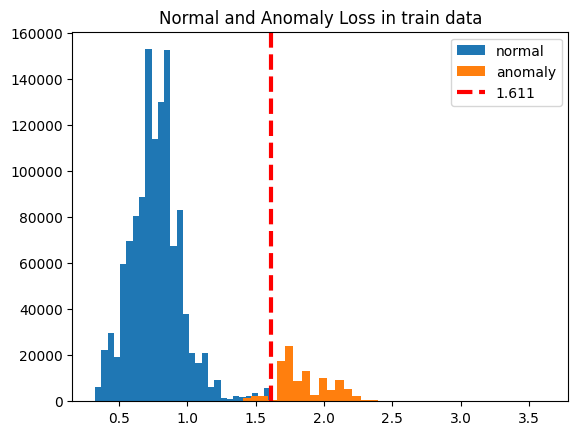

13695/13695 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
fold10 results
Auc: 0.9992484489479228
Accuracy: 0.9945345714031433
Precision: 0.987815362722718
Recall: 0.9438024019941084
F1 Score: 0.9653074527413631

 Cross-Validation Results (10-fold avg):
Auc: 0.9940
Accuracy: 0.9840
Precision: 0.8639
Recall: 0.8399
F1 Score: 0.8490


In [ ]:
for i, (train_index, test_index) in enumerate(skf.split(x, y)):
    print(f"Fold {i + 1}:")

    x_train , x_test = x.iloc[train_index].copy(), x.iloc[test_index].copy()
    y_train, y_test = y[train_index].copy(), y[test_index].copy()

    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoder.fit(x_train[categorical_cols])

    x_train_categorial = pd.DataFrame(encoder.transform(x_train[categorical_cols]),
                                    columns=encoder.get_feature_names_out(categorical_cols),
                                    index=x_train.index)
    x_test_categorial = pd.DataFrame(encoder.transform(x_test[categorical_cols]),
                                    columns=encoder.get_feature_names_out(categorical_cols),
                                    index=x_test.index)


    #Scale numerical features with MinMaxScaler fit on train, then applying on val and test
    scaler = MinMaxScaler()
    scaler.fit(x_train[numerical_cols])

    train_num_scaled = pd.DataFrame(scaler.transform(x_train[numerical_cols]), columns=numerical_cols, index=x_train.index)
    test_num_scaled = pd.DataFrame(scaler.transform(x_test[numerical_cols]), columns=numerical_cols, index=x_test.index)


    # Combine encoded categorical and scaled numerical features
    x_train = pd.concat([x_train_categorial, train_num_scaled], axis=1)
    x_test = pd.concat([x_test_categorial, test_num_scaled], axis=1)

    #Autoencoders for Anomaly Detection train only on normal samples
    x_train_normal = x_train[y_train == 0].copy()

    x_test.to_csv(f'/content/drive/MyDrive/data/x_test_fold_{i+1}.csv', index=False)
    np.savetxt(f'/content/drive/MyDrive/data/y_test_fold_{i+1}.csv',y_test,delimiter=',')
    x_train.to_csv(f'/content/drive/MyDrive/data/x_train_fold_{i+1}.csv', index=False)
    np.savetxt(f'/content/drive/MyDrive/data/y_train_fold_{i+1}.csv',y_train,delimiter=',')

    autoencoder = AnomalyDetector(x_train.shape[1])
    optimizer = optimizers.Adam()
    autoencoder.compile(optimizer=optimizer, loss=keras.losses.binary_crossentropy)

    history = autoencoder.fit(x_train_normal, x_train_normal,
            epochs=40,
            batch_size=50,
            validation_data=(x_train,x_train))

    autoencoder.save(f'/content/drive/MyDrive/data/model{i+1}.keras')

    # #compute best threshold (regarding to F1 metric) on train data
    train_loss = keras.losses.binary_crossentropy(autoencoder.predict(x_train), x_train)
    precision, recall, thresholds = metrics.precision_recall_curve(y_train, train_loss)
    f1_scores = 2 * precision * recall / (precision + recall)
    best_index = np.argmax(f1_scores)
    threshold = thresholds[best_index]
    print(f"Threshold: {threshold}")

      #plot histogran for normal and abnormal train data
    plt.hist(keras.losses.binary_crossentropy(autoencoder.predict(x_train[y_train == 0]), x_train[y_train == 0]), bins=50, label='normal')
    plt.hist(keras.losses.binary_crossentropy(autoencoder.predict(x_train[y_train == 1]), x_train[y_train == 1]), bins=50, label='anomaly')
    plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold))
    plt.legend(loc='upper right')
    plt.title("Normal and Anomaly Loss in train data")
    plt.show()



    all_fold_histories.append(history)
    all_fold_models.append(autoencoder)

    reconstructions = autoencoder.predict(x_test)
    loss = keras.losses.binary_crossentropy(reconstructions, x_test)
    pred = loss > threshold

    fpr, tpr, thresholds = metrics.roc_curve(y_test, loss)
    auc = metrics.auc(fpr, tpr)
    acc = metrics.accuracy_score(y_test, pred)
    precision = metrics.precision_score(y_test, pred)
    recall = metrics.recall_score(y_test, pred)
    f1 = metrics.f1_score(y_test, pred)

    print(f"fold{i+1} results")
    print("Auc:", auc)
    print("Accuracy:", acc)
    print("Precision:",precision )
    print("Recall:", recall)
    print("F1 Score:", f1)
    all_fold_metrics.append((auc ,acc, precision, recall, f1))


results = np.array(all_fold_metrics)
print("\n Cross-Validation Results (10-fold avg):")
print(f"Auc: {results[:,0].mean():.4f}")
print(f"Accuracy: {results[:,1].mean():.4f}")
print(f"Precision: {results[:,2].mean():.4f}")
print(f"Recall: {results[:,3].mean():.4f}")
print(f"F1 Score: {results[:,4].mean():.4f}")


the following cell is for adjusting and evaluating the model for fold number 5 in which the resutls weren't good on train data. It loads the saved training and testing data for fold 5, loads the trained model for fold 5, and calculates the reconstruction loss on the training data. It then iterates through different thresholds to find the best threshold for maximizing the F1 score on Train data. And prints the evaluation metrics (AUC, Accuracy, Precision, Recall, and F1 Score)based  on test data . It is important to say that the threshold is seleceted based only the train data.

In [ ]:
#adjustment for fold num 5:
x_test = pd.read_csv('/content/drive/MyDrive/data/x_test_fold_5.csv')
y_test = np.loadtxt('/content/drive/MyDrive/data/y_test_fold_5.csv')
x_train = pd.read_csv('/content/drive/MyDrive/data/x_train_fold_5.csv')
y_train = np.loadtxt('/content/drive/MyDrive/data/y_train_fold_5.csv')


model = keras.saving.load_model('/content/drive/MyDrive/data/model5.keras')

reconstructions = model.predict(x_train)
loss = keras.losses.binary_crossentropy(reconstructions, x_train)
scores = []
for i in range(10):
  pred = loss > (1 + 0.1*i)

  fpr, tpr, thresholds = metrics.roc_curve(y_train, loss)
  auc = metrics.auc(fpr, tpr)
  acc = metrics.accuracy_score(y_train, pred)
  precision = metrics.precision_score(y_train, pred)
  recall = metrics.recall_score(y_train, pred)
  f1 = metrics.f1_score(y_train, pred)
  scores.append((auc,acc,precision,recall,f1))

scores = np.array(scores)
max = np.argmax(scores[:,4])
all_fold_metrics[4] = scores[max]
print(f"fold{5}")
print("Auc:", scores[max][0])
print("Accuracy:",  scores[max][1])
print("Precision:", scores[max][2] )
print("Recall:",  scores[max][3])
print("F1 Score:",  scores[max][4])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41083/41083 ━━━━━━━━━━━━━━━━━━━━ 63s 1ms/step
fold5
Auc: 0.9995404998253595
Accuracy: 0.9986262262984101
Precision: 0.9896526098939863
Recall: 0.9933341516150048
F1 Score: 0.9914899632456884


## Cross-Validation Results Summary

This cell summarizes the cross-validation results. It takes the evaluation metrics (AUC, Accuracy, Precision, Recall, and F1 Score) from each completed fold, calculates the average for each metric across all folds, and prints the average cross-validation results. This provides an overall performance assessment of the anomaly detection model.

In [ ]:
results = np.array(all_fold_metrics)
print("\n Cross-Validation Results (10-fold avg):")
print(f"Auc: {results[:,0].mean():.4f}")
print(f"Accuracy: {results[:,1].mean():.4f}")
print(f"Precision: {results[:,2].mean():.4f}")
print(f"Recall: {results[:,3].mean():.4f}")
print(f"F1 Score: {results[:,4].mean():.4f}")



 Cross-Validation Results (10-fold avg):
Auc: 0.9940
Accuracy: 0.9919
Precision: 0.9629
Recall: 0.9392
F1 Score: 0.9482
